# **Exercise session 2: Convolutional neural network to detect NO$_2$ emissions from satellite data**

In this exercise session you will train a convolutional neural network (CNN) to detect NO$_2$ plumes from Sentinel-5P TROPOMI instrument. This exercise is designed to be completed on Aalto JupyterHub. Please ensure that your notebook includes all necessary installation commands for any additional libraries your code requires. These commands should be clearly written and integrated within your notebook.

In [6]:
!pip install torchsummary

In [7]:
# Importing necessary libraries

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


## **Exercise 2.1: Data preparation**

In the previous exercise session, you built a small dataset of 20 images containing a plume and 20 images containing no plume. These images have been combined with those from your classmates to form a larger dataset, suitable for training a convolutional neural network (CNN). Your task now is to prepare this dataset for the training process.
1. The pixel values in your images should be normalized to have values between 0 and 1. This is a common practice in image processing for neural networks, as it helps with the convergence during training.
2. Separate the data into training, validation and test sets:
   - **Training set:** Used for training the CNN. Typically, this is the largest portion of the data.
   - **Validation set:** Used to tune the hyperparameters and evaluate the models during training.
   - **Test set:** Used to test the model after the training process is complete. This set should only be used once to evaluate the final model performance.

A common split ratio is 70% training, 15% validation, and 15% test. However, the exact split may depend on the size of your dataset.

In [8]:
def process_images(root_dir, classes, min_size=64, transform=None):
    processed_data = []
    
    class_to_idx = {"plumes": 1, "n-plumes": 0}

    for class_folder in os.listdir(root_dir):
        if class_folder in classes:
            class_folder_path = os.path.join(root_dir, class_folder)
            if not os.path.isdir(class_folder_path):
                continue
            for img_filename in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_filename)
                try:
                    with Image.open(img_path) as img:
                        # Remove too small images
                        if img.size[0] < min_size or img.size[1] < min_size:
                            continue
                        # Crop too large images
                        if img.size[0] > min_size or img.size[1] > min_size:
                            img = transforms.CenterCrop((min_size, min_size))(img)
                        img_tensor = transform(img)
                        label = class_to_idx[class_folder]  # Convert label to plume/no plume
                        processed_data.append((img_tensor, label))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    return processed_data


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.type(torch.FloatTensor)),
    transforms.Normalize((0.5,), (0.5,)) 
])

root_dir = '/coursedata'  
classes = ["plumes", "n-plumes"]

processed_dataset = process_images(root_dir, classes, min_size=64, transform=transform)

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

dataset = CustomDataset(processed_dataset)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#for i, data in enumerate(test_loader, 0):
#    print(data[0].shape)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Error processing /coursedata/n-plumes/.ipynb_checkpoints: [Errno 21] Is a directory: '/coursedata/n-plumes/.ipynb_checkpoints'
Error processing /coursedata/plumes/.ipynb_checkpoints: [Errno 21] Is a directory: '/coursedata/plumes/.ipynb_checkpoints'
Training set size: 891
Validation set size: 191
Test set size: 192


## **Exercise 2.2: Build a convolutional neural network model**

Build a basic CNN model using a framework like TensorFlow or PyTorch. You can use [the code from this tutorial](https://www.tensorflow.org/tutorials/images/cnn) for constructing a simple CNN. The model doesn't need to be very deep; a few convolutional layers should be enough. Explain your model construction in your own words.

Model structure guidelines (that you can ignore):
1. **Input layer:** Your input layer should match the dimensions of your plume images.
2. **Convolutional layers:**
   - Start with 2-3 convolutional layers.
   - Use small filters/kernels (like 3x3 or 5x5) to capture the image features.
   - Apply activation functions like ReLU to introduce non-linearity.
3. **Pooling layers:** After each convolutional layer, add a pooling layer (like max pooling) to reduce the spatial dimensions of the output volume.
4. **Flatten layer:** Flatten the output from the convolutional layers before feeding it into the fully connected layers.
5. **Fully connected (dense) layers:**
   - A couple of dense layers at the end of the network for classification.
   - The last dense layer should have the number of units equal to the number of classes and use a softmax activation function for multi-class classification.
6. **Compile the model:**
   - Compile the model with an appropriate optimizer (like Adam or SGD).
   - Choose a suitable loss function (like binary_crossentropy for binary classification).
   - Include accuracy as a metric for model performance evaluation.

In [9]:
class PlumeCNN(nn.Module):
    def __init__(self):
        super(PlumeCNN, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        # softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

model = PlumeCNN().to(device)

print(model)

PlumeCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 62, 62]             208
         MaxPool2d-2            [-1, 8, 31, 31]               0
            Conv2d-3           [-1, 16, 29, 29]           3,216
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 12, 12]          12,832
         MaxPool2d-6             [-1, 32, 6, 6]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                   [-1, 64]          73,792
            Linear-9                    [-1, 2]             130
Total params: 90,178
Trainable params: 90,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.47
Params size (MB): 0.34
Estimated Total Size (MB): 0.83
---------------------------------------------

## **Exercise 2.3: Train the model**

1. Use the training and validation data to train the model.
2. Monitor the loss and accuracy metrics over epochs to observe the training process.
3. Save the model (optional): After training, you can save your model for future use.

Things to Monitor:
- **Overfitting:** If your model performs well on training data but poorly on validation data, it might be overfitting. Consider using dropout layers or getting more data.
- **Underfitting:** If the model performs poorly on both training and validation data, it might be underfitting. Consider adding complexity to your model or training for more epochs.

In [11]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for epoch in range(1, num_epochs + 1):
    model.train()  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = calculate_accuracy(train_loader, model)
    
    # Calculate loss and accuracy 
    model.eval() 
    val_loss = sum(loss_function(model(images.to(device)), labels.to(device)).item() 
                   for images, labels in val_loader) / len(val_loader)
    val_accuracy = calculate_accuracy(val_loader, model)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}')
        print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%')
        torch.save(model.state_dict(), f'optimal_models/model_epoch_{epoch}.pth')
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)

print('Finished Training')

Epoch 10/200
Train loss: 0.5226, Train accuracy: 82.15%
Validation loss: 0.5094, Validation accuracy: 79.58%
Epoch 20/200
Train loss: 0.4666, Train accuracy: 84.85%
Validation loss: 0.4823, Validation accuracy: 82.72%
Epoch 30/200
Train loss: 0.4620, Train accuracy: 84.62%
Validation loss: 0.5237, Validation accuracy: 78.01%
Epoch 40/200
Train loss: 0.4643, Train accuracy: 85.07%
Validation loss: 0.5290, Validation accuracy: 77.49%
Epoch 50/200
Train loss: 0.4749, Train accuracy: 83.61%
Validation loss: 0.5406, Validation accuracy: 76.44%
Epoch 60/200
Train loss: 0.4530, Train accuracy: 85.86%
Validation loss: 0.5208, Validation accuracy: 78.53%
Epoch 70/200
Train loss: 0.4757, Train accuracy: 84.85%
Validation loss: 0.5170, Validation accuracy: 78.53%
Epoch 80/200
Train loss: 0.4462, Train accuracy: 85.52%
Validation loss: 0.5204, Validation accuracy: 78.53%
Epoch 90/200
Train loss: 0.4487, Train accuracy: 85.41%
Validation loss: 0.5345, Validation accuracy: 76.96%
Epoch 100/200
Train

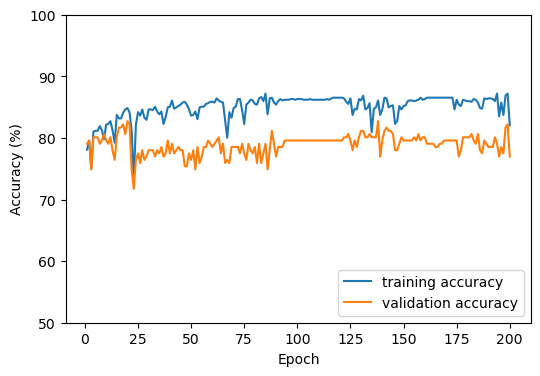

In [12]:
plt.figure(figsize=(6,4))

plt.plot(range(1, num_epochs+1), train_accuracy_list, label='training accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_list, label ='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim([50, 100])
plt.legend(loc=4)

## **Exercise 2.4: Model evaluation**

After training your model, the next step is to evaluate its performance using the test set. This step is crucial to understand how well your model will perform on unseen data. Some common metrics to evaluate a CNN that performs a classification task are
- **Accuracy:** Measures the percentage of correctly predicted instances out of all predictions. It's straightforward but can be misleading in cases of class imbalance.
- **Precision** (Positive predictive value): The ratio of correctly predicted positive observations to the total predicted positives. It's important when the cost of False Positives is high.
- **Recall** (sensitivity, true positive rate): The ratio of correctly predicted positive observations to all actual positives. Crucial when the cost of false negatives is high.
- **F1 score:** The weighted average of precision and recall. Useful as a single metric when you need a balance between precision and recall.
- **Confusion matrix:** A table layout that allows visualization of the performance of an algorithm. Shows the number of true positives, false positives, true negatives, and false negatives.

Accuracy: 0.7604
Precision: 0.7696
Recall: 0.7604
F1 Score: 0.7610


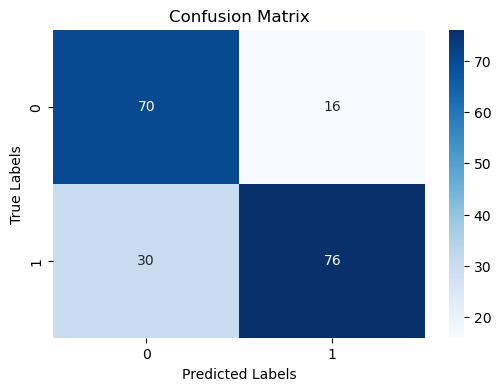

In [13]:
model = PlumeCNN().to(device)

# Epoch 20 has both highest training and highest validation error
model_path = 'optimal_models/model_epoch_20.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

def get_predictions(loader, model):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels

test_predictions, test_labels = get_predictions(test_loader, model)

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Exercise 2.5: Visualization of results**

Visualize model predictions: Choose a subset of your test dataset and display the images with their predicted and actual labels. This is particularly useful to see how the model performs on individual examples.

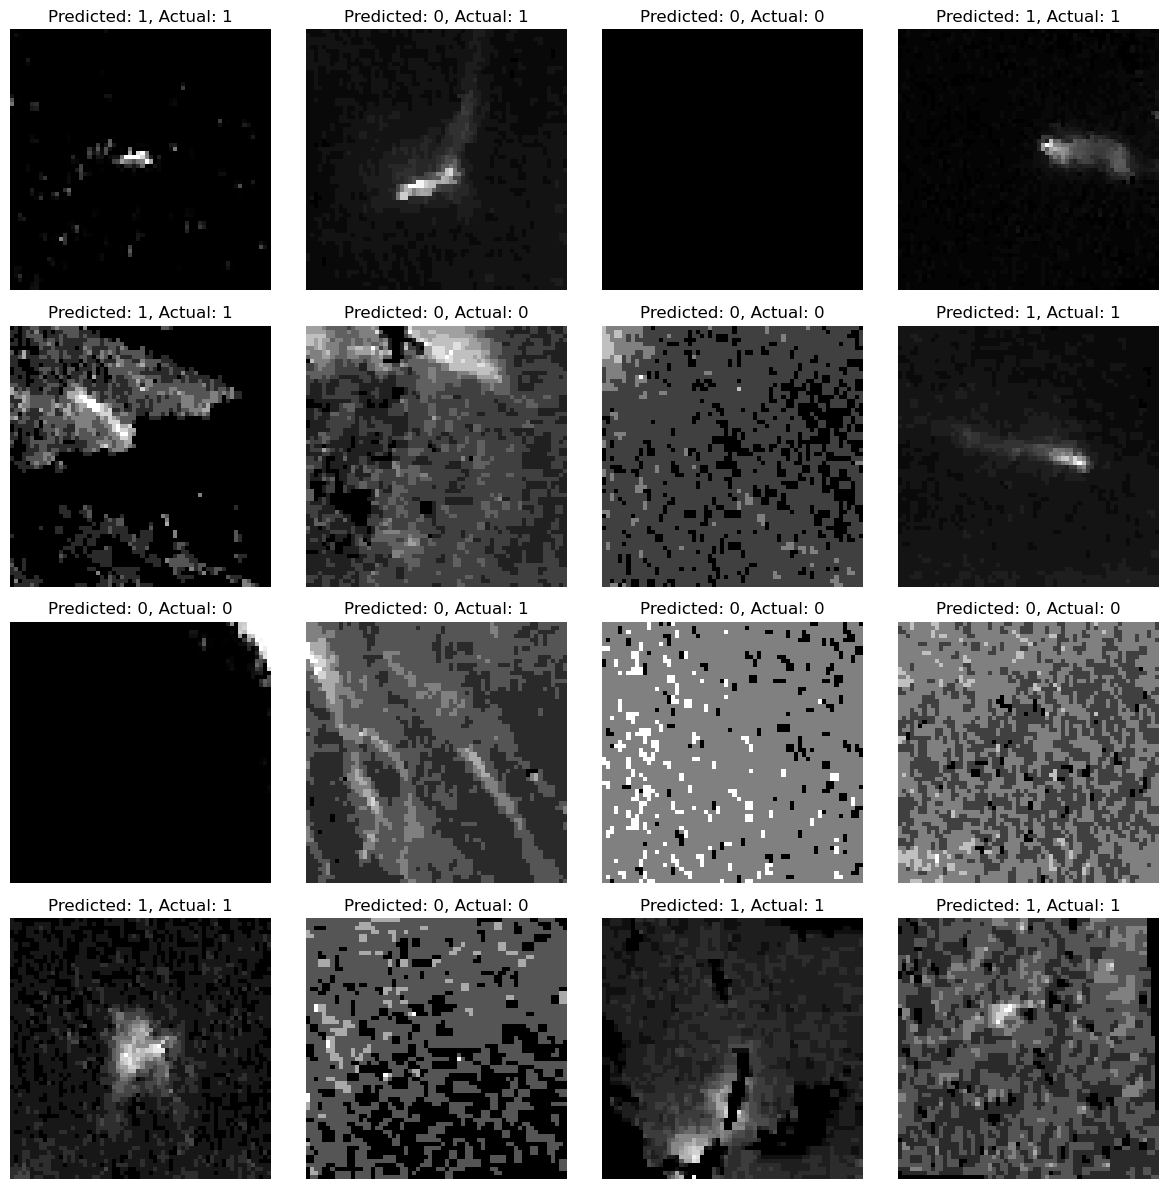

0 means no plume and 1 means plume


In [14]:
model.eval()

test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

with torch.no_grad():
    outputs = model(test_images)
    _, predicted = torch.max(outputs, 1)

num_images = 16

fig, axes = plt.subplots(4, 4, figsize=(12, 12))  
axes = axes.ravel() 

for i in range(num_images):
    ax = axes[i]
    ax.imshow(np.transpose(test_images[i].cpu().numpy(), (1, 2, 0)), cmap='gray')
    ax.set_title(f'Predicted: {predicted[i].item()}, Actual: {test_labels[i].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("0 means no plume and 1 means plume")

## **Exercise 2.6: Test your model on the real world** (Optional)

1. Pick an area of roughly 500 000 km$^2$ that includes industrial activity, and consider a period of around one month to ensure enough data. Use Copernicus Browser for a preliminar analysis of a good area.
2. Retrieve Sentinel-5P NO$_2$ data from that area and that time period.
3. Prepare the data to fit your CNN. The images you feed your CNN need to be of size 64x64 pixels. Make sure you retain the coordinates of your data to be able to locate potential power plants or cities later.
4. Look for plumes using your trained CNN.
5. How many plumes can you find? Can you link them to any known city or power plant?

**Note:** You will need to identify cloud covered-areas and exclude them from the dataset. You can also interpolate missing values due to clouds if there are only a few missing values.

## **Exercise 2.7: Overview**

Reflect on the entire process you've undertaken, from the initial data collection to building and training your machine learning algorithm, and finally evaluating this algorithm in a real-world setting. Which step did you find the most challenging, and why? Additionally, were there any unexpected difficulties or learning experiences along the way? How do you think these challenges could be addressed in future projects? (Imagine this was a task in your job, this is not a question on how to improve homework exercises!)

---

**Initial data collection**: extremely time consuming and quite annoying because I cannot easily fine a NO2 plume on the Sentinel 5P despite searching for places around the power stations on many days of overpass. I gave up and only found 2 sensible images. Additionally, rescaling the pixels to 64 x 64 is also troublesome, and I must exactly create a crop square on Copernicus Browser that results in exactly 64 x 64 pixels to avoid image modification later. Data collection is the hardest, most time-consuming and possibly most boring work. 

**Building and training machine learning algorithm**: quite straightforward as there are lots of tutorials on the net and I simply change the parameters to fit the our case. The hard thing in this stage is only model selection, like how many kernels I should use for each CNN and how I should choose the padding size. I also consider using BCELoss during training process and output of the model is a single floating number, but it performs very badly, so I went with the general classification architecture, which is softmax on the last linear layer whose number of nodes is number of class (2) 

**Evaluating this algorithm in a real-world setting**: this is probably not that difficult, as we can simply scale the images for the ML model and obtain the prediction. However, I did admit that the model performs not well on the testing dataset, which is only around 80%. It would be nice if I can further improve this accuracy to 85%, which is ideal 

How these challenges could be addressed in future projects: data cleaning and data quality is of utmost importance. I have a feeling that some plume images are just chosen randomly on the Copernicus browser by students to simply complete their assignment. If we have more data and better quality data, the model could have perform much better

## **Exercise 2.8: Comparison**
Compare your approach for detecting NO$_2$ plumes with the method described in the class-reviewed paper [Automated detection of atmospheric NO$_2$ plumes from satellite data: a tool to help infer anthropogenic combustion emissions.](https://amt.copernicus.org/articles/15/721/2022/). Focus on key differences and similarities in the data processing techniques, CNN architecture, and overall detection strategy. Briefly discuss how these differences might impact the effectiveness of plume detection

Discuss how using a plume detection algorithm based on a CNN model can be utilized for climate action. Interpret the results, noting any interesting observations, and suggest potential areas for model improvement. Could other approaches be better for such a task? What steps would you take next?

---
The approach for detecting NO2 plumes using CNN in this exercise and in the paper shows both similarities and differences in methodologies:

- Data preparation: Both approaches normalizes the image pixel values for model training. The paper's method of using a subset of TROPOMI data, which is basically similar to what is done in this exercise on a balanced dataset of plume and no-plume images.

- CNN Architecture: The paper's CNN architecture is optimized for NO2 plume detection from satellite data, similar to the basic CNN model structure in this exercise. Both approaches use convolutional layers, pooling layers, and fully connected layers. However, the CNN model in the paper is more detailed than our own design, which can handle atmospheric data from the TROPOMI instrument on Sentinel-5P, including four convolutional and two fully connected layers. This design allows the model to identify NO2 plumes by analyzing patterns in 28×28 pixel images of atmospheric observations. The model uses maximum pooling and dropout to reduce overfitting

- Detection strategy: The paper has the thermal anomaly data to distinguish between biomass burning and anthropogenic emissions, an approach not covered by this exercise. This additional feature can help us detect plumes with higer accuracy.

- Effectiveness for climate action: Both methods shows that CNN-based models can contribute to climate action by identifying emission hotspots. The paper's analysis of plume distribution relative to anthropogenic CO2 emissions suggests some proactive measures on  reducing emission inventories. 

- Model improvement: The paper's success in finding a significant percentage of CO2 emissions through NO2 plume detection shows the effectiveness of its method. This exercises however suggest model tuning through training and validation to improve model accuracy.

- Next steps: Based on the paper, we can further improve the CNN model by incorporating additional environmental parameters or using other ML models, which could provide a detailed description of emission patterns.